# Quick tests outside of Test macro

In [1]:
using TestEnv
TestEnv.activate()

"/tmp/jl_M85oHj/Project.toml"

In [147]:
using Dynamigal
using Test
using PythonCall
using CairoMakie
using BenchmarkTools
#



pyimport("sys")."path".append("")
pyimport("sys")."path".append("../python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

#### Setting up initial conditions and potentials in both Gala and GalacticDynamics

In [26]:
Δt = 0.001
n_step = 10000
t₁ = 0.0
t₂ = t₁ + n_step*Δt
@show t₂
t_range = (t₁, t₂)
x₀ = -50.0*SA[1,0,0]
v₀ = 200.0*SA[0,1,0]
# x₀ = 30*[1,0,1]
# v₀ = 100*[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

t₂ = 10.0


Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

### Orbit plot with Gala and GalacticDynamics


𝕤.ode = Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
sol_gala.t[-1] = <py Quantity 10. Gyr>
sol.t[end] = 10.0
findmax(sol_diff) = (0.0007411761949659978, 9492)


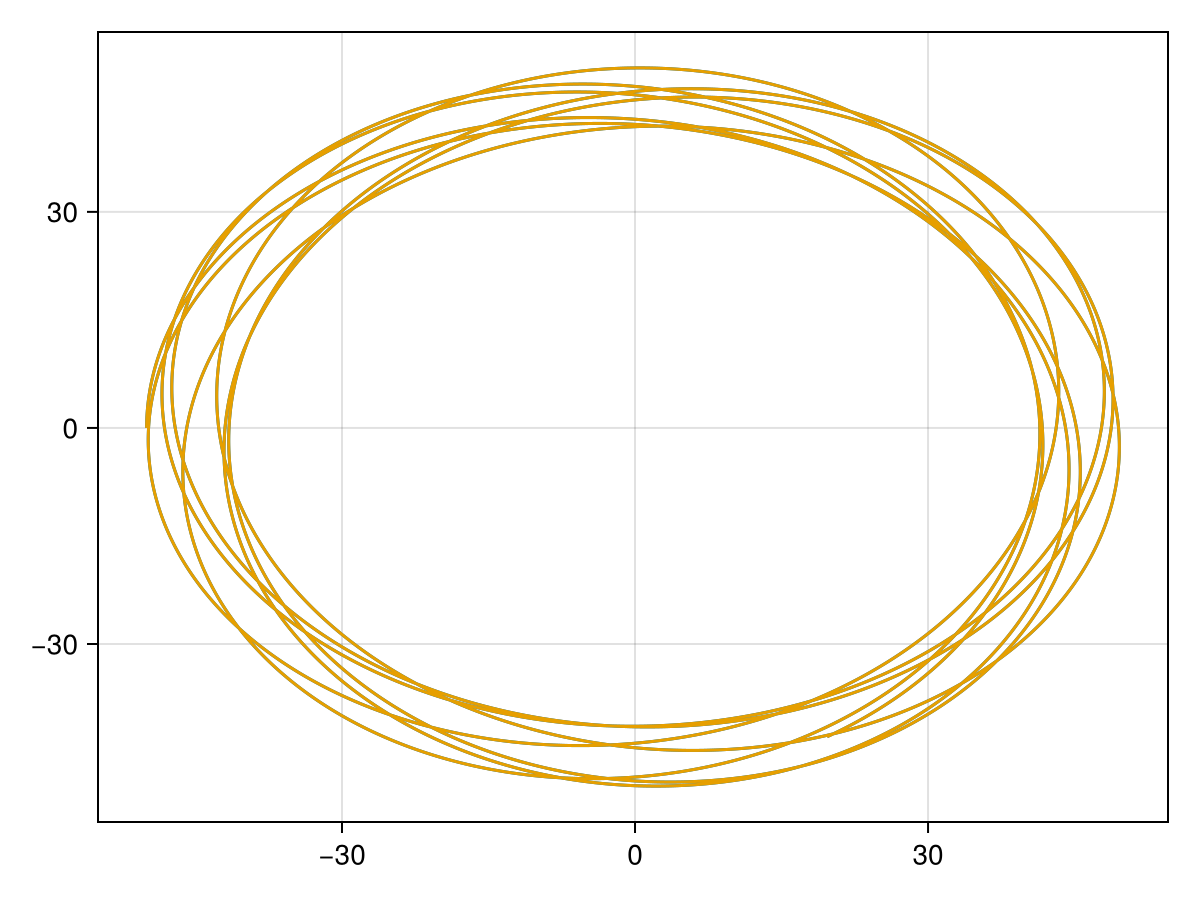

In [27]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂+1.e-7)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-8)))
sol = evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-8, saveat=Δt))

@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



### Precision

#### Precision test between Gala and Dynamigal
##### For the NFW
Adding `atol=0.5e-16` in both Gala and Dynamigal improves the precision by two orders of magnitude, only when `rtol` is already very small (`< 10^{-16}`).

In [30]:
orb₁ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=t₂*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-10)))
orb₂ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-12)))
orb₃ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-16)))
orb₄ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-10, saveat=Δt))
orb₅ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-12, saveat=Δt))
orb₆ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))
orb₇ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-10, saveat=Δt))
orb₈ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-12,saveat=Δt))
orb₉ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))
@show orb₁.x[-1]  orb₂.x[-1]  orb₃.x[-1]
@show orb₄.x[1,end]  orb₅.x[1,end]  orb₆.x[1,end]
@show orb₇.x[1,end]  orb₈.x[1,end]  orb₉.x[1,end]
@show orb₄.x[1,end]-orb₁.x[-1].value  orb₅.x[1,end]-orb₂.x[-1].value  orb₆.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₁.x[-1].value  orb₈.x[1,end]-orb₂.x[-1].value  orb₉.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₄.x[1,end]  orb₈.x[1,end]-orb₅.x[1,end]  orb₉.x[1,end]-orb₆.x[1,end]
@test orb₄.x[1,end] ≈ pyconvert(Float64,orb₁.x[-1].value)  rtol=5.0e-7
@test orb₅.x[1,end] ≈ pyconvert(Float64,orb₂.x[-1].value)  rtol=5.0e-9
@test orb₆.x[1,end] ≈ pyconvert(Float64,orb₃.x[-1].value)  rtol=5.0e-12


orb₁.x[-1] = <py Quantity 19.67263649 kpc>
orb₂.x[-1] = <py Quantity 19.67263649 kpc>
orb₃.x[-1] = <py Quantity 19.67263649 kpc>
orb₄.x[1, end] = 19.6726364711186
orb₅.x[1, end] = 19.672636487031482
orb₆.x[1, end] = 19.672636487175843
orb₇.x[1, end] = 19.67263645665499
orb₈.x[1, end] = 19.67263648689424
orb₉.x[1, end] = 19.67263648718241
orb₄.x[1, end] - (orb₁.x[-1]).value = <py -1.6099175326189652e-08>
orb₅.x[1, end] - (orb₂.x[-1]).value = <py -1.8629364717526187e-10>
orb₆.x[1, end] - (orb₃.x[-1]).value = <py -4.193267955088231e-11>
orb₇.x[1, end] - (orb₁.x[-1]).value = <py -3.056278785606992e-08>
orb₈.x[1, end] - (orb₂.x[-1]).value = <py -3.235349765873252e-10>
orb₉.x[1, end] - (orb₃.x[-1]).value = <py -3.5367264672458987e-11>
orb₇.x[1, end] - orb₄.x[1, end] = -1.4463612529880265e-8
orb₈.x[1, end] - orb₅.x[1, end] = -1.3724132941206335e-10
orb₉.x[1, end] - orb₆.x[1, end] = 6.565414878423326e-12


Test Passed

#### Precision test between Gala and Dynamigal
##### For the MN disk

In [31]:
gp = pyimport("gala.potential")
gd= pyimport("gala.dynamics")
gu = pyimport("gala.units")
pot_mn = gp.MiyamotoNagaiPotential(m=2.5E11*au.Msun, a=6.5*au.kpc,b=0.26*au.kpc, units=gu.galactic)
w0 = gd.PhaseSpacePosition(pos=Py([11., 0., 0.2])*au.kpc, vel=Py([0., 200, 100])*au.km/au.s)
orb₁ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator)
orb₂ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
orb₃_c = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator,  cython_if_possible=true, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₃ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₄ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator)
orb₅ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
@show orb₁.x[-1] orb₂.x[-1] orb₃_c.x[-1] orb₃.x[-1]  orb₄.x[-1] orb₅.x[-1];

orb₁.x[-1] = <py Quantity 6.76980261 kpc>
orb₂.x[-1] = <py Quantity 6.76980261 kpc>
orb₃_c.x[-1] = <py Quantity 6.76980252 kpc>
orb₃.x[-1] = <py Quantity 6.76980252 kpc>
orb₄.x[-1] = <py Quantity 6.74183738 kpc>
orb₅.x[-1] = <py Quantity 6.74183738 kpc>


#### This is another NFW orbit test that originally couldn't be integrated in Julia due to abrupt reduction of step size.
#### Problem solved: I was taking an initial condition that with radial orbit!

In [32]:
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
Δt = 0.01
n_step = 1000
t₁ = 0.0
t₂ = t₁ + n_step*Δt
@show t₂
t_range = (t₁, t₂)

x₀ = 30*[1,0,1]
v₀ = 200*[0,1,0]
m = 10^12*𝕦.m  # Msun
a = 20*𝕦.l
pot = NFW(m, a)
pot_Gala = gp.NFWPotential(Py(adimensional(m))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
@show pot_Gala

# Gala.py solution
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)
orb_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
Integrator=gi.DOPRI853Integrator,Integrator_kwargs=Py(Dict("rtol"=>5.0e-14, "atol"=>0.5e-14)))
orb_gala_t = pyconvert(Vector{Float64}, orb_gala.t)
orb_gala_x = pyconvert(Vector{Float64}, orb_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, orb_gala.y)
orb_gala_z = pyconvert(Vector{Float64}, orb_gala.z)
# GalacticDynamics.jl solution
sol = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(; reltol=5.0e-14, abstol=0.5e-14, saveat=Δt))
@show sol.t
orb_t = ustrip.(physical_units.(sol.t,:t))
orb_x = sol.x[1,:]

@test orb_t[end] ≈ orb_gala_t[end] rtol=5.0e-12
@test orb_x[end] ≈ orb_gala_x[end] rtol=5.0e-12

t₂ = 10.0
pot_Gala = <py NFWPotential: m=1.00e+12, r_s=20.00, a=1.00, b=1.00, c=1.00 (kpc,Gyr,solMass,rad)>
sol.t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49

Test Passed

### Speed tests

#### BenchmarkTools only tests memory consumption on the Julia side. The time is real as long as C is not working asynchronously.

In [82]:
Δt_g = Δt*au.Gyr
t₂_g = t₂*au.Gyr

Python: <Quantity 10. Gyr>

In [150]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt_g, t1=t₁, t2=t₂_g,
                                    Integrator=gi.LeapfrogIntegrator,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16)))

BenchmarkTools.Trial: 3650 samples with 1 evaluation per sample.
 Range (min … max):  1.163 ms …  38.935 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.272 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.359 ms ± 773.830 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ██ ▁                                                       
  ████▇██▆▅▅▄▄▄▄▅▄▄▄▄▃▃▃▃▂▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.16 ms         Histogram: frequency by time        1.98 ms <

 Memory estimate: 1.34 KiB, allocs estimate: 39.

In [86]:
@benchmark pot_Gala.integrate_orbit($w₀, dt=$Δt_g, t1=$t₁, t2=$t₂_g,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16)))

BenchmarkTools.Trial: 1669 samples with 1 evaluation per sample.
 Range (min … max):  2.562 ms …   6.678 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.904 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.980 ms ± 334.619 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▄▅█▆█▇█▇▆▆▂▅▂                                            
  ▄▅▇██████████████▇▆▅▆▆▅▅▄▅▄▄▄▃▃▂▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▃▁▁▁▂▂▂ ▄
  2.56 ms         Histogram: frequency by time        4.34 ms <

 Memory estimate: 2.56 KiB, allocs estimate: 114.

In [116]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt_g, t1=t₁, t2=t₂_g,
                                    Integrator=gi.DOPRI853Integrator,
                                    cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16)))

BenchmarkTools.Trial: 1631 samples with 1 evaluation per sample.
 Range (min … max):  2.565 ms …  30.984 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.934 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.048 ms ± 797.410 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▂▄▆▅▄██▅▄▂▃▁                                             
  ▅▇▇██████████████▆▇▆▅▄▅▄▃▄▄▃▃▃▂▂▃▂▃▂▂▂▁▂▂▂▂▁▂▂▂▂▂▂▂▃▂▃▃▃▂▂▂ ▄
  2.56 ms         Histogram: frequency by time        4.58 ms <

 Memory estimate: 2.77 KiB, allocs estimate: 115.

In [155]:
@benchmark pot_Gala.integrate_orbit($w₀, dt=$Δt_g, t1=$t₁, t2=$t₂_g,
                                    Integrator=gi.DOPRI853Integrator,
                                    cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16)))


BenchmarkTools.Trial: 1748 samples with 1 evaluation per sample.
 Range (min … max):  2.541 ms …  33.451 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.802 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.846 ms ± 755.305 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▁▃▂▄▇▅▄▇▅▂█▅▄▃▄▃▅▃▃▅▁▂▃ ▁▁▁▂ ▁                         
  ▄▅▄▆██████████████████████████████▆██▇▇▆▆▅▅▅▅▆▄▃▃▁▃▃▄▂▃▂▂▂▂ ▅
  2.54 ms         Histogram: frequency by time        3.29 ms <

 Memory estimate: 2.80 KiB, allocs estimate: 117.

In [157]:
@benchmark evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  282.901 μs …   6.155 ms  ┊ GC (min … max): 0.00% … 88.21%
 Time  (median):     297.487 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   323.338 μs ± 180.131 μs  ┊ GC (mean ± σ):  3.24% ±  5.58%

  ▆█▇█▇▆▅▅▅▄▃▂▃▃▃▂▁▂▁▁▁▁▁▁                                      ▂
  ██████████████████████████▇█▇▇▇▇▇▇▆▆▆▆▆▆▇▆█▆▇▆▇▆▅▅▆▅▆▄▅▅▆▃▅▅▅ █
  283 μs        Histogram: log(frequency) by time        526 μs <

 Memory estimate: 281.81 KiB, allocs estimate: 166.

In [77]:
@benchmark evolve($pot, $x₀, $v₀, $t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, saveat=$Δt))

BenchmarkTools.Trial: 3088 samples with 1 evaluation per sample.
 Range (min … max):  1.433 ms …   9.716 ms  ┊ GC (min … max): 0.00% … 72.12%
 Time  (median):     1.531 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.612 ms ± 288.546 μs  ┊ GC (mean ± σ):  0.48% ±  2.70%

    █▅▃▃                                                       
  ▂▂████▇▆▅▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.43 ms         Histogram: frequency by time        2.36 ms <

 Memory estimate: 282.12 KiB, allocs estimate: 161.

In [92]:
@benchmark evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))

BenchmarkTools.Trial: 6853 samples with 1 evaluation per sample.
 Range (min … max):  636.470 μs …   6.631 ms  ┊ GC (min … max): 0.00% … 80.77%
 Time  (median):     686.936 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   724.829 μs ± 224.160 μs  ┊ GC (mean ± σ):  1.79% ±  5.00%

     ▂█▇▃▁                                                       
  ▂▅▅█████▆▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  636 μs           Histogram: frequency by time         1.02 ms <

 Memory estimate: 285.15 KiB, allocs estimate: 161.

In [94]:
@benchmark evolve($pot, $x₀, $v₀, $t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, saveat=$Δt))

BenchmarkTools.Trial: 3142 samples with 1 evaluation per sample.
 Range (min … max):  1.432 ms …   8.054 ms  ┊ GC (min … max): 0.00% … 72.34%
 Time  (median):     1.524 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.585 ms ± 243.064 μs  ┊ GC (mean ± σ):  0.43% ±  2.66%

     ▁█▆▃▂▁                                                    
  ▄▃▅███████▆▅▆▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁ ▂
  1.43 ms         Histogram: frequency by time        2.07 ms <

 Memory estimate: 282.12 KiB, allocs estimate: 161.

In [95]:
@benchmark _evolve($pot, $x₀, $v₀, $t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, saveat=$Δt))

BenchmarkTools.Trial: 3176 samples with 1 evaluation per sample.
 Range (min … max):  1.420 ms …   8.436 ms  ┊ GC (min … max): 0.00% … 73.99%
 Time  (median):     1.507 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.569 ms ± 256.290 μs  ┊ GC (mean ± σ):  0.51% ±  2.94%

  ▃▃▄█▇▆▇▆▅▅▅▄▃▃▂▂▂▁▁▁                                        ▁
  ████████████████████████████▇█▇███▇▇█▇█▆▅▄▇▅▅▄▆▄▄▅▅▆▃▆▄▆▄▄▄ █
  1.42 ms      Histogram: log(frequency) by time      2.18 ms <

 Memory estimate: 281.80 KiB, allocs estimate: 154.

In [60]:
# Profile package not installed
# ProfileSVG.@profview evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, saveat=Δt))

#### Benchmark difference between using or not @unpack macro inside functions, making a more costy function by evaluating in 1000 random points.

In [104]:
function potential_packed(pot::MiyamotoNagaiDisk, x::AbstractArray{T}) where {T<:Real}
    y = @view x[1:2]
    return -G*pot.m/sqrt( dot(y,y) + (pot.a + sqrt(pot.b^2+x[3]^2))^2 )
end
pot = MiyamotoNagaiDisk(10.0^11, 30., 5.)

MiyamotoNagaiDisk{Float64, Float64, Float64}
  m: Float64 1.0e11
  a: Float64 30.0
  b: Float64 5.0


In [102]:
x = [rand(3) for i ∈ 1:1000]
f(x) = potential(pot,x)
@benchmark f.($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  35.394 μs …  15.616 ms  ┊ GC (min … max): 0.00% … 99.44%
 Time  (median):     39.549 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   42.958 μs ± 156.069 μs  ┊ GC (mean ± σ):  3.61% ±  0.99%

  ███▅▄▆▇█▆▅▄▃▃▃▂▂▁ ▁▁   ▁▁▁▁ ▁▁▂▁                             ▃
  ████████████████████▇███████████████▇▇▇▇▇▆▇▅▇▇▆▆▇▆▆▄▆▇▆▅▅▅▅▆ █
  35.4 μs       Histogram: log(frequency) by time      77.5 μs <

 Memory estimate: 23.77 KiB, allocs estimate: 1010.

In [105]:
f_packed(x) = potential_packed(pot,x)
@benchmark f_packed.($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  34.335 μs …  14.832 ms  ┊ GC (min … max): 0.00% … 99.39%
 Time  (median):     38.785 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   41.451 μs ± 148.172 μs  ┊ GC (mean ± σ):  3.56% ±  0.99%

  ▄▇█▅▄▃▅▇▇▆▄▃▂▂▂▂▂▁▁                                          ▂
  █████████████████████▆▇▇▆▇▆████▇▇███▇▇▇▇▇▇▆▆▇▇▆▆▆▆▆▅▅▅▅▄▅▅▅▆ █
  34.3 μs       Histogram: log(frequency) by time      72.7 μs <

 Memory estimate: 23.77 KiB, allocs estimate: 1010.

There is a difference of only `1 μs` in favor of not using `@unpack` macro, but it is worth for tidyness.

Using `y = @view x[1:2]` and `dot(y,y)` instead of `y'y` makes the difference.